<a href="https://colab.research.google.com/github/angelohafner/linguagem-de-programacao-udesc/blob/main/euler_second_order_with_solve_ivp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second-Order ODEs with Python's Built-in Solver (solve_ivp)

This notebook solves **second-order ODEs** using `scipy.integrate.solve_ivp` (Runge–Kutta methods and others). We convert each 2nd-order ODE to a 1st-order **state-space** system and call `solve_ivp`.

Notes:
- Comments in code are in English.
- No compound assignment operators are used.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def uniform_time_grid(t0, tf, n_points):
    # Create a uniform time grid for evaluation
    return np.linspace(t0, tf, n_points)

def plot_states(t, Y, labels, title_text):
    # One plot for multiple state series (each column in Y)
    plt.figure()
    for i in range(Y.shape[0]):
        plt.plot(t, Y[i, :], label=labels[i])
    plt.xlabel('t')
    plt.ylabel('state')
    plt.title(title_text)
    plt.legend()
    plt.grid(True)
    plt.show()


## 1) Mass–Spring–Damper (free response)
Model: `m y'' + c y' + k y = 0`. Define state x = [y, v]^T, where v = y'. Then:
```
y' = v
v' = -(c/m) v - (k/m) y
```
Solution uses `solve_ivp` with default RK45.


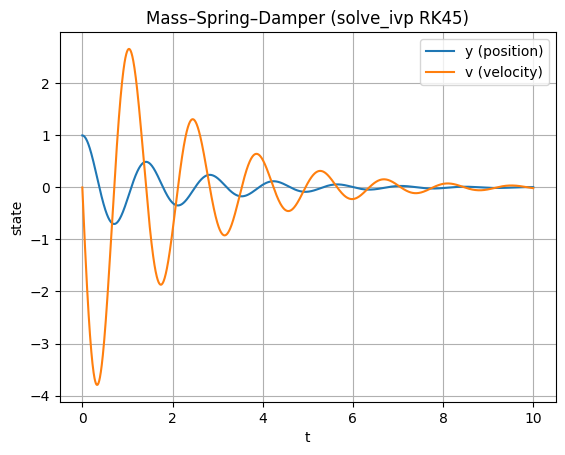

In [2]:
m = 1.0
c = 1.0
k = 20.0
t0 = 0.0
tf = 10.0
y0 = 1.0
v0 = 0.0
t_eval = uniform_time_grid(t0, tf, 2000)

def msd_rhs(t, x):
    y = x[0]
    v = x[1]
    dy = v
    dv = -(c / m) * v - (k / m) * y
    return [dy, dv]

sol = solve_ivp(msd_rhs, (t0, tf), [y0, v0], t_eval=t_eval, method='RK45')
plot_states(sol.t, sol.y, ['y (position)', 'v (velocity)'], 'Mass–Spring–Damper (solve_ivp RK45)')


## 2) Simple Pendulum (nonlinear)
Equation: `θ'' + (g/L) sin(θ) = 0`. Let state x = [θ, ω]^T, with ω = θ'. Then:
```
θ' = ω
ω' = -(g/L) sin(θ)
```


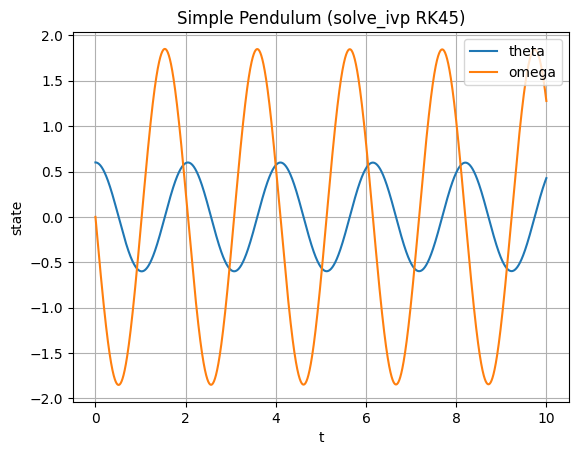

In [3]:
g = 9.81
L = 1.0
t0 = 0.0
tf = 10.0
theta0 = 0.6
omega0 = 0.0
t_eval = uniform_time_grid(t0, tf, 4000)

def pend_rhs(t, x):
    theta = x[0]
    omega = x[1]
    dtheta = omega
    domega = -(g / L) * np.sin(theta)
    return [dtheta, domega]

sol_p = solve_ivp(pend_rhs, (t0, tf), [theta0, omega0], t_eval=t_eval, method='RK45')
plot_states(sol_p.t, sol_p.y, ['theta', 'omega'], 'Simple Pendulum (solve_ivp RK45)')


## 3) Series RLC (step input)
Let `q` be capacitor charge. Equation: `L q'' + R q' + (1/C) q = Vin(t)`. With current `i = q'`:
```
q' = i
i' = (Vin(t) - R i - (1/C) q) / L
```
Capacitor voltage: `Vc = q / C`.


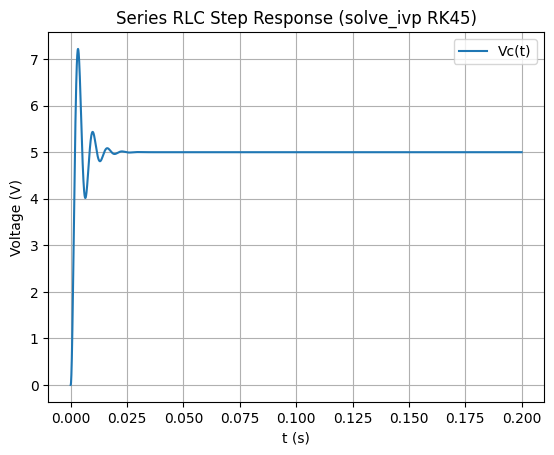

In [4]:
Lv = 10e-3
Rv = 5.0
Cv = 100e-6
Vstep = 5.0
t0 = 0.0
tf = 0.2
q0 = 0.0
i0 = 0.0
t_eval = uniform_time_grid(t0, tf, 4000)

def Vin(t):
    return Vstep

def rlc_rhs(t, x):
    q = x[0]
    i = x[1]
    dq = i
    di = (Vin(t) - Rv * i - (1.0 / Cv) * q) / Lv
    return [dq, di]

sol_r = solve_ivp(rlc_rhs, (t0, tf), [q0, i0], t_eval=t_eval, method='RK45')
Vc = sol_r.y[0, :] / Cv
plt.figure()
plt.plot(sol_r.t, Vc, label='Vc(t)')
plt.xlabel('t (s)')
plt.ylabel('Voltage (V)')
plt.title('Series RLC Step Response (solve_ivp RK45)')
plt.legend()
plt.grid(True)
plt.show()


## 4) Projectile with Linear Drag (2D) + Event Stop
State x = [px, py, vx, vy]. Model:
```
px' = vx
py' = vy
vx' = -(k/m) vx
vy' = -g -(k/m) vy
```
We stop integration when `py` returns to ground (0 m) after launch, using an **event**.


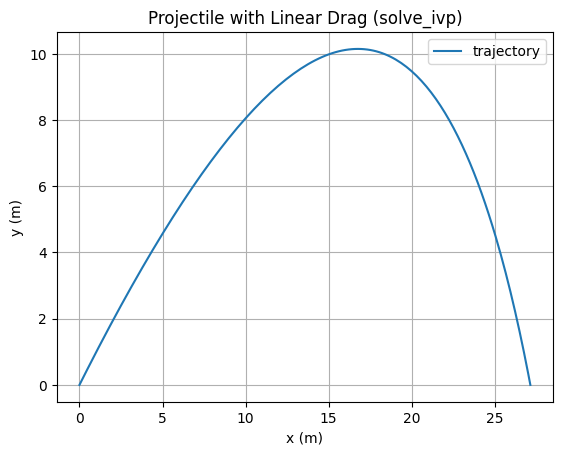

In [5]:
mproj = 0.2
kdrag = 0.1
g = 9.81
t0 = 0.0
tf = 6.0
px0 = 0.0
py0 = 0.0
v0 = 25.0
angle = 45.0 * np.pi / 180.0
vx0 = v0 * np.cos(angle)
vy0 = v0 * np.sin(angle)

def proj_rhs(t, x):
    px = x[0]
    py = x[1]
    vx = x[2]
    vy = x[3]
    dpx = vx
    dpy = vy
    dvx = -(kdrag / mproj) * vx
    dvy = -g - (kdrag / mproj) * vy
    return [dpx, dpy, dvx, dvy]

def hit_ground(t, x):
    return x[1]
hit_ground.terminal = True
hit_ground.direction = -1

sol_proj = solve_ivp(proj_rhs, (t0, tf), [px0, py0, vx0, vy0], events=hit_ground, dense_output=False, max_step=0.02)
t_traj = sol_proj.t
Y_traj = sol_proj.y
plt.figure()
plt.plot(Y_traj[0, :], Y_traj[1, :], label='trajectory')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Projectile with Linear Drag (solve_ivp)')
plt.legend()
plt.grid(True)
plt.show()


### Methods available
`solve_ivp` supports methods like `'RK45'` (default), `'RK23'`, `'Radau'` (stiff), `'BDF'` (stiff), and `'LSODA'`. If your problem is stiff (e.g., large damping or very disparate time scales), try `'Radau'` or `'BDF'`.
